In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import tensorflow as tf
import talos as ta
#from talos.model.layers import hidden_layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, LocallyConnected1D, Conv1D, Reshape
from keras.callbacks import ModelCheckpoint, History
from keras.activations import relu, elu, linear
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from tqdm import trange

plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.figsize'] = [10.0, 4.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 12

Using TensorFlow backend.


In [3]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [4]:
#data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")
#data = data_pd.to_numpy(); data_pd.describe()
data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")[::100][["LIMIT_BAL", "PAY_1", "default payment next month"]]
data = data_pd.to_numpy(); data_pd.describe()

,LIMIT_BAL,PAY_1,default payment next month
count,191.000000,191.000000,191.000000
mean,117853.403141,0.136126,0.251309
std,82946.396619,1.110857,0.434906
min,10000.000000,-2.000000,0.000000
25%,50000.000000,0.000000,0.000000
50%,100000.000000,0.000000,0.000000
75%,175000.000000,1.000000,0.500000
max,360000.000000,4.000000,1.000000


In [5]:
#input_data = data[:,1:-1]
#output_data = data[:,-1]
#nr_params = input_data.shape[1]; nr_params
input_data = data[:,:-1]
output_data = data[:,-1]
nr_params = input_data.shape[1]
nr_datapoints = input_data.shape[0]; nr_params, nr_datapoints

(2, 191)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_test_scaled = Scaler.transform(X_test)

In [7]:
opti = optimizers.Adam(amsgrad=True)
def nn_reg():
    model = Sequential()
    model.add(Dense(8, input_shape=(nr_params,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(1, activation="sigmoid", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss="binary_crossentropy",  metrics=["accuracy"])
    return model
nn_reg().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


In [8]:
clf = KerasRegressor(build_fn=nn_reg, batch_size=16, epochs=100, validation_split=0.2, verbose=1)
history = clf.fit(X_train_scaled, Y_train.reshape(-1,1))

Train on 114 samples, validate on 29 samples
Epoch 1/100
114/114 [==============================] - 0s 2ms/step - loss: 0.6920 - accuracy: 0.7456 - val_loss: 0.6904 - val_accuracy: 0.7586
Epoch 2/100
114/114 [==============================] - 0s 73us/step - loss: 0.6897 - accuracy: 0.7368 - val_loss: 0.6879 - val_accuracy: 0.7586
Epoch 3/100
114/114 [==============================] - 0s 77us/step - loss: 0.6875 - accuracy: 0.7368 - val_loss: 0.6852 - val_accuracy: 0.7586
Epoch 4/100
114/114 [==============================] - 0s 87us/step - loss: 0.6849 - accuracy: 0.7368 - val_loss: 0.6820 - val_accuracy: 0.7586
Epoch 5/100
114/114 [==============================] - 0s 87us/step - loss: 0.6819 - accuracy: 0.7368 - val_loss: 0.6789 - val_accuracy: 0.7586
Epoch 6/100
114/114 [==============================] - 0s 98us/step - loss: 0.6792 - accuracy: 0.7368 - val_loss: 0.6751 - val_accuracy: 0.7586
Epoch 7/100
114/114 [==============================] - 0s 97us/step - loss: 0.6757 - accurac

In [9]:
Y_pred = clf.predict(X_test_scaled)
Y_pred = np.where(Y_pred > 0.5, 1, 0)

48/48 [==============================] - 0s 173us/step


In [10]:
accuracy_score(Y_pred, Y_test)

0.7916666666666666

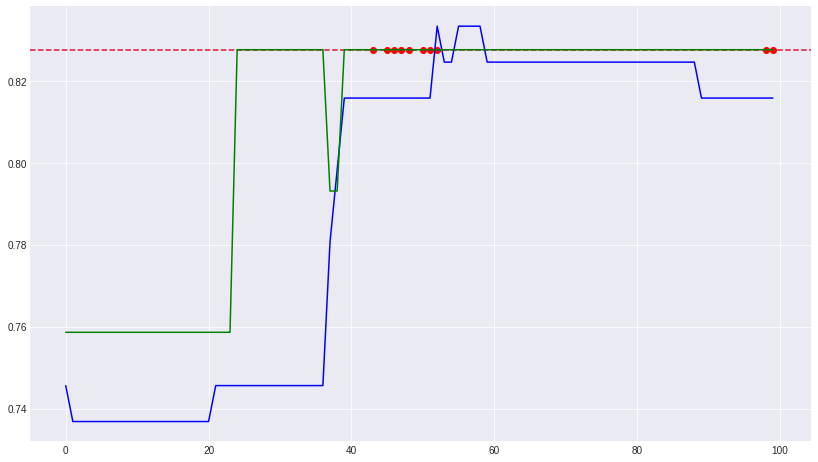

In [11]:
plt.figure(figsize=(14,8))
acc = np.array(history.history["accuracy"])
val_acc = np.array(history.history["val_accuracy"])
asdf = np.argsort(val_acc)[-10:]
plt.axhline(y=val_acc[asdf[0]], c="crimson", ls="--")
plt.plot(acc, c="b")
plt.plot(val_acc, c="g")
plt.scatter(asdf, val_acc[asdf], c="r")